In [28]:
import torch
import yfinance as yf
import pandas as pd

import time
import os.path

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
# prepare device
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

In [3]:
# print up/down in --o--o- format
def puts(arr): print(''.join(["o" if x > 0 else '-' for x in arr]))

In [4]:
tickers = ['^SPX']

In [5]:
# 回看過去的窗口
rolling_back = 120

In [6]:
# 觀察窗口
expect_period = 1 # 30min

In [7]:
model_path = 'model_friday_5.pt'

In [8]:
period = "10d" # 5 day 390 rows
interval = "5m"

In [9]:
# 下載數據，合併成一個 df
if len(tickers) > 1:
	dfs = yf.download(tickers, period=period, interval=interval, group_by='Ticker')
	df_global = pd.concat([dfs[k].add_prefix(k + "_") for k in tickers], axis=1)
else:
	df_global = yf.download(tickers, period=period, interval=interval).add_prefix(tickers[0] + "_")

df_global

[*********************100%%**********************]  1 of 1 completed


,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Close,^SPX_Adj Close,^SPX_Volume
Datetime,,,,,,
2024-02-05 09:30:00-05:00,4957.189941,4957.189941,4946.750000,4950.649902,4950.649902,152938651
2024-02-05 09:35:00-05:00,4950.439941,4950.479980,4944.830078,4946.799805,4946.799805,103643688
2024-02-05 09:40:00-05:00,4946.919922,4948.040039,4944.680176,4947.750000,4947.750000,85784024
2024-02-05 09:45:00-05:00,4947.689941,4950.319824,4946.640137,4947.950195,4947.950195,79302652
2024-02-05 09:50:00-05:00,4947.850098,4948.689941,4945.439941,4948.100098,4948.100098,74423956
...,...,...,...,...,...,...
2024-02-16 15:35:00-05:00,5016.140137,5016.500000,5011.629883,5012.060059,5012.060059,54369388
2024-02-16 15:40:00-05:00,5012.089844,5012.089844,5005.359863,5006.509766,5006.509766,75685062
2024-02-16 15:45:00-05:00,5006.459961,5008.359863,5000.640137,5000.839844,5000.839844,92109550


In [10]:
def prepare_data(df):
    # 相對於起始位置的改變
    diffs = df.diff(rolling_back).add_suffix("_Diff")
    
    # diff to N days ago
    diffs_9 = df.diff(9).add_suffix("_Diff9")
    diffs_18 = df.diff(18).add_suffix("_Diff18")
    diffs_27 = df.diff(27).add_suffix("_Diff27")
    
    hist_diffs = pd.concat([diffs, diffs_9, diffs_18, diffs_27], axis=1)
    
    # 同一個 slot 內相對於 Open 的改變
    slot_diffs = []
    for k in tickers:
        tg = "Open"
        for fg in ["Close", "High", "Low"]:
            slot_diff = df["%s_%s" % (k, fg)] - df["%s_%s" % (k, tg)] 
            slot_diff.name = "%s_%s_%s" % (k, fg, tg)
            slot_diffs.append(slot_diff)
    
    slot_diffs = pd.concat(slot_diffs, axis=1)
    
    all_diffs = pd.concat([hist_diffs, slot_diffs], axis=1).fillna(0)
    # print(all_diffs.columns)
    
    
    # 補充一些技術指標
    extra_series = []
    for k in all_diffs.columns:
        sma_9 = all_diffs[k].rolling(9).mean()
        for i in [26, 40]:
            sma_tg = all_diffs[k].rolling(i).mean()
            sma_cross = sma_9 - sma_tg
            sma_cross.name = "%s_SMA_9cross%d" % (k, i)
            extra_series.append(sma_cross)
        
        ema12 = all_diffs[k].ewm(span=12, adjust=False).mean()
        for i in [26, 40]:
            ema_tg = all_diffs[k].ewm(span=i, adjust=False).mean()
            macd = ema12 - ema_tg
            macd.name = "%s_MACD_12cross%d" % (k, i)
            extra_series.append(macd)
        
            macd_signal = macd.ewm(span=9, adjust=False).mean()
            macd_signal.name = "%s_signal" % macd.name
            extra_series.append(macd_signal)
    
    extra_series = pd.concat(extra_series, axis=1)
    
    combine = pd.concat([all_diffs, extra_series], axis=1).fillna(0)
    # print(combine)
    
    # 把過去 N 天的數據拉成一行
    rolling_back_series = []
    for k in combine.columns:
        series = pd.Series([w.tolist() for w in combine[k].rolling(rolling_back)], name=k)
        rolling_back_series.append(series)
    
    container = pd.concat(rolling_back_series, axis=1)
    # print(container)
    
    # 每一行合併成一個 list
    list_container = container.apply(lambda row: sum(row, []), axis = 1)
    
    # 去頭去尾
    train_data = list_container[rolling_back:-expect_period]
    
    # 轉成 tensor
    train_set = torch.Tensor(train_data.tolist()).to(device)
    
    # 末尾作為測試
    recent_data = list_container[-expect_period:]
    recent_set = torch.Tensor(recent_data.tolist()).to(device)
    
    return train_set, recent_set

In [11]:
def prepare_exp(df):
	close = df['^SPX_Close'][::-1]
    
	close = close.rolling(expect_period + 1).apply(lambda x: x.iloc[expect_period] / x.iloc[0]).fillna(0)

	# 再反回來
	close = close[::-1]

	# 放大信號
	close = (close.values - 1) * 500

	# model 輸出層是 1 個 node
	close = [[x] for x in close]

	return close

In [18]:
def prepare_model(input_size):
    sigmoid_layer = torch.nn.Sigmoid()
    
    layers = []
    layers.append(torch.nn.Linear(input_size, 400))
    layers.append(sigmoid_layer)
    layers.append(torch.nn.Linear(400, 200))
    layers.append(sigmoid_layer)
    layers.append(torch.nn.Linear(200, 1))
    # layers.append(sigmoid_layer)
    
    model = torch.nn.Sequential(*layers).to(device)
    # model = nn_model.MLPClassifier(nn_data.input_size).to(nn_data.device)
    if os.path.isfile(model_path):
        model = torch.load(model_path).to(device)
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
    loss_function = torch.nn.MSELoss()
    # loss_function = torch.nn.L1Loss()
    # loss_function = torch.nn.BCELoss()
    return model, optimizer, loss_function

In [20]:
hist = []
hist_file = "hist5.csv"

rest_len = 390

for i in range(rest_len - 5):
    clear_output(wait=True)
    print("-- loop %d --" % i)
    df = df_global[i:i + rest_len]
    # print(df)

    print("-- prepare data --")
    train_set, recent_set = prepare_data(df)
    
    print("-- prepare expected data --")
    # 用 global 才有未來的數據
    # expect_set, recent_exp = prepare_exp(df)
    close = prepare_exp(df_global)
    expect_data = close[i + rolling_back: i + rest_len - expect_period]
    expect_set = torch.Tensor(expect_data).to(device)
    
    recent_exp = close[i + rest_len - expect_period:i + rest_len]
    # print(recent_exp)
    
    input_size = train_set.shape[1]
    print("input size: %d" % input_size)
    
    print("-- prepare model --")
    model, optimizer, loss_function = prepare_model(input_size)

    print("-- start training --")
    start_time = time.time()
    
    epochs = 5000 if i == 0 else 500
    for epoch in range(epochs):
        prediction = model(train_set)
        
        loss = loss_function(prediction, expect_set)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if epoch % 100 == 0:
            torch.save(model, model_path)
            print(epoch, loss.item())	
        
    # save again
    torch.save(model, model_path)
    
    # load the model from file, avoid model data effect
    model = torch.load(model_path)

    print("-- check prediction --")
    predictions = model(train_set)
    # print("Predictions : \n", predictions.detach().cpu())
    
    # save expected data and prediction data to file
    x_close = pd.DataFrame(expect_set.tolist())
    p_close = pd.DataFrame(predictions.tolist())
    rr = pd.concat([x_close, p_close], axis=1)
    rr.columns = ['ori', 'exp']
    rr.to_csv('rr.csv', index=False)
    
    print("exps:")
    puts(expect_set)
    print("runs:")
    puts(predictions)
    # puts(pd.DataFrame(predictions.tolist())[0].values)
    # puts(predictions.detach().round().cpu())
    
    error = loss_function(predictions, expect_set)
    print("Error : ", error.detach().cpu().numpy())
    
    print(model(recent_set))
    print(recent_exp)
    hist.append([model(recent_set).tolist()[0][0], recent_exp[0][0]])
    pd.DataFrame(hist).to_csv(hist_file, index=False)
    print("--- loop: %d ---" % i)
    print("--- run time: %s seconds ---" % (time.time() - start_time))

-- loop 384 --
-- prepare data --
-- prepare expected data --
input size: 22680
-- prepare model --
-- start training --
0 0.002943393774330616
100 1.881142793536128e-06
200 8.151558006375126e-08
300 6.320354017930185e-09
400 7.300569038193316e-10
-- check prediction --
exps:
--oooo--oo-o-ooo-ooo-o---ooo-o--oo--------o-o--oo---oooo-ooo-o--oo-o--oo------o--oo-oo-o---o-oooo-o----o-o---o---o---o---o-o------oo-o---oo-o--o--oo--o--o-o--o-oo---o-ooo-----o--o-o---ooo-oo--o-o--ooo-oo----o-o-oo-o-----o-o-o---ooo--ooo-ooooo--o---o----oo-oooooo-o-o--o
runs:
--oooo--oo-o-ooo-ooo-o---ooo-o--oo--------o-o--oo---oooo-ooo-o--oo-o--oo------o--oo-oo-o---o-oooo-o----o-o---o---o---o---o-o------oo-o---oo-o--o--oo--o--o-o--o-oo---o-ooo-----o--o-o---ooo-oo--o-o--ooo-oo----o-o-oo-o-----o-o-o---ooo--ooo-ooooo--o---o----oo-oooooo-o-o--o
Error :  1.0293829e-10
tensor([[0.1103]], device='mps:0', grad_fn=<LinearBackward0>)
[[0.0099777967252912]]
--- loop: 384 ---
--- run time: 3.3340392112731934 seconds ---


In [22]:
L1Loss = torch.nn.L1Loss()
MSELoss = torch.nn.MSELoss()

In [24]:
# check hist diffs
hist = pd.read_csv(hist_file)

model_result = torch.Tensor(hist.iloc[:, 0])
actual_result = torch.Tensor(hist.iloc[:, 1])

print(L1Loss(model_result, actual_result))
print(MSELoss(model_result, actual_result))

tensor(0.2825)
tensor(0.3139)


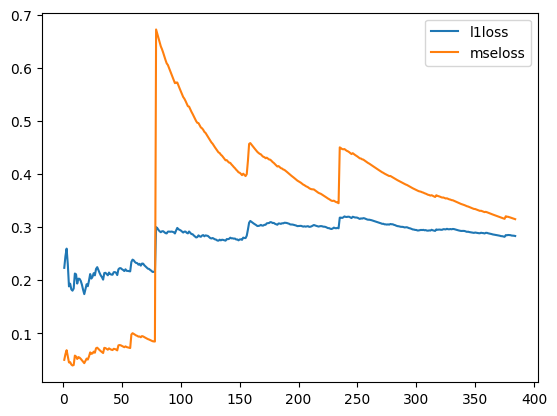

In [35]:
l1loss_hist = []
mseloss_hist = []

for i in range(hist.shape[0]):
    ds = hist[:i]
    model_result = torch.Tensor(ds.iloc[:, 0])
    actual_result = torch.Tensor(ds.iloc[:, 1])
    l1loss_hist.append(L1Loss(model_result, actual_result))
    mseloss_hist.append(MSELoss(model_result, actual_result))

plt.plot(l1loss_hist, label="l1loss")
plt.plot(mseloss_hist, label="mseloss")
plt.legend()
plt.show()